# SENIOR PROJECT by Egor Isakson

---



## Intro

For my senior project I analyzed equities. I have grown to be really passionate about financial markets and programming at the same time, so I did not want to miss an opportunity to display this passionate of both subjects in a formal matter.

I have been getting inspiration for this kind of project ever since I got interested in trading. I have been told that automating trading is impossible or way too difficult, that successful trading is based on intuition only. I've heard the reverse, too. However, even if I wanted to from the start, I lacked a trading edge, meaning I could not pin point what exactly on the chart (or not) led to a succesful trade. On top of that, I simply did not have the skills to implement this technically. 

However, I have been gaining experience in both progressively over these past couple of years, and I have felt that I randomly came across certain random things, like pieces of code, or stack overflow posts, that kind of cleared things up for me. It's like they were some bread crumbs that I was following that finally led to this project.





## About the project

The project itself is a trading research environment. I built an infrastructure to make datasets that I could later clean, insert into a neural network and evaluate the results.

There are several components to this trading environment
- downloading data from a 3rd party vendor
- storing and updating data
- drawing variously defined trendlines
- computing various features for each trendline
- labeling the outcome of each data
- compressing all the requested data into one piece (a single csv)


# About this notebook's data

For my first data set that came out of the trading research environment, I decided to explore bullish descending trendline breakouts on a daily chart. Having the most trading experience in this particular area (but absolutely with lots of room to grow), I thought this would be a fitting area of research.

I understood that I would not have time to verify every single feature that I chose and would need to come with some kind of features in the first place. Thus, the selection and design of features in this dataset was purely a gut feel. It is whatever I thought was important to convey to the model that I would have considered important in my decision-making myself.


## About features and labels

### Features

- "pole_length_1" -> pole length in number of candles elapsed
- "pole_flag_length_ratio_1" -> pole's length in candles / flag's length in candles
-"flag_low_progress" -> time of flag's low with respect to its stage in flag development
- "pivot_to_flag_height_ratio" -> end of breakout range / entire flag's height
- "pole_height_in_candles" -> pole height in terms of average candle's range
- "pole_flag_height_ratio" -> pole price range / height price range

I intentionally avoided including prices and percentages directly because I thought they are meaningless in their original form. Each feature is based on some kind of relation to another element in the setup. Each feature is built to be relative to something.

Essentially, these are all features of a pole and a flag -> two elements of triangle breakout.

### Labels

-  "label_class_2_num_of_lows_2_profit_r"

I am aiming to only get a general idea whether a trendline is going to be successful or not, without diving further how good is the trendline. 


## Trendline data inspection

In [2]:
# adding data from my school's google drive account

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls "/content/gdrive/My Drive/4. Senior 2021/Senior Project (trading)"

 all_current_tickers.csv		 'Metadata of data.gdoc'
 latest_big_bull_triangles_big_data.csv   old_big_bull_triangles_big_data.csv


In [4]:
root_path = "/content/gdrive/My Drive/4. Senior 2021/Senior Project (trading)/latest_big_bull_triangles_big_data.csv"

In [5]:
# all dependencies

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection  import train_test_split
import numpy as np

In [6]:

original_df = pd.read_csv(root_path)
original_df.head()


,t_start,t_end,price_start,price_end,slope,intercept,rvalue,pvalue,base_length,preciseness,pole_length_1,pole_flag_length_ratio_1,flag_low_timestamp,flag_low_price,flag_low_progress,pivot_to_flag_height_ratio,pole_start_timestamp,pole_start_price,pole_height_in_candles,pole_flag_height_ratio,stop_loss_2_num_of_lows,entry_pos,profit_price_2_profitable_r_2_num_of_lows,label_class_2_num_of_lows_2_profit_r,ticker,avg_v_20
0,1099976400000,1101272400000,18.5185,16.09,-0.232438,83.729744,-0.982277,0.000080,11,2,21.0,1.909091,1100235600000,15.6585,0.333333,0.849126,1097553600000,15.4655,6.528945,1.067483,16.2520,16.5737,17.2171,True,A,3.669455e+06
1,1099976400000,1101877200000,18.5185,16.33,-0.166848,65.547648,-0.999971,0.004812,15,2,21.0,1.400000,1100235600000,15.6585,0.250000,0.765210,1097553600000,15.4655,6.528945,1.067483,16.2949,16.9384,18.2254,False,A,3.669455e+06
2,1099976400000,1101877200000,18.5185,16.25,-0.156286,62.352670,-0.988153,0.000029,15,3,21.0,1.400000,1100235600000,15.6585,0.250000,0.793182,1097553600000,15.4655,6.528945,1.067483,16.2949,16.9384,18.2254,False,A,3.669455e+06
3,1099976400000,1100667600000,18.5185,15.81,-0.491097,156.262010,-0.894448,0.016124,6,3,21.0,3.500000,1100235600000,15.6585,0.571429,0.947028,1097553600000,15.4655,6.528945,1.067483,16.1290,16.7096,17.8708,False,A,3.669455e+06
4,1099976400000,1101099600000,18.5185,15.97,-0.259192,90.878500,-0.788452,0.011577,9,5,21.0,2.333333,1100235600000,15.6585,0.400000,0.891084,1097553600000,15.4655,6.528945,1.067483,16.2949,16.5022,16.9168,False,A,3.669455e+06


Not all of this dataset's columns are features, or intended to be used as features at the moment. Some of them like: slope, intercept,	flag_low_price were either a by-product that I thought would be interesting to expore later or derived in the process of making other features.

In [7]:
original_df.shape

(1265328, 26)

As I estimated before assembling all the data together, the total number of trendlines drawn exceeds 1 million. When it came to deciding criteria for starting points of trendlines, these were the following:
- higher highs of higher highs (recursive process of first finding higher highs and then selecting higher highs among those left from the first call)
- average volume of last 20 candles MUST be above 50k (I have included average volume in this dataset as well, in case this must be filtered further)

# Visualization insights

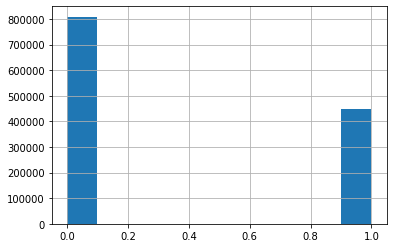

In [8]:

original_df["label_class_2_num_of_lows_2_profit_r"].astype(float).hist()

In this dataset, a label is either 1 or 0. 1 if a setup is successful; 0 if not. Interestingly, there are more successful trades than I thought there would be.


In [9]:
original_df["label_class_2_num_of_lows_2_profit_r"].value_counts()

False    809088
True     448429
Name: label_class_2_num_of_lows_2_profit_r, dtype: int64

In [10]:
print("Portion of successful setups")
round(448429 / (809088 + 448429), 2)

Portion of successful setups


0.36

There's a 36% chance that a trendline will be successful. Given that the risk/reward is 1:2, here is our expected value:

In [11]:
p_right = 0.36
r_right = 2

p_wrong = 0.64
r_wrong = 1

round(p_right * r_right - p_wrong * r_wrong, 2)

0.08

Thus, it looks like we can expect to be profitable by simply relying on our linear regression's trendline drawing skills, without even training a neural network:)

Now, let's examine if there's some relationship between average volume and the outcome

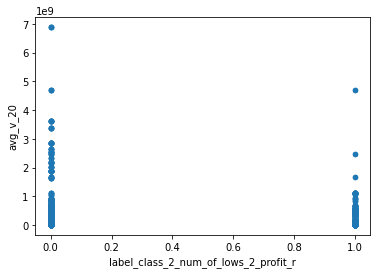

In [12]:
original_df.plot.scatter("label_class_2_num_of_lows_2_profit_r", "avg_v_20" )

Looks like there are more trades with volume greater than 1 that have failed, but let's examine this further, if the charts is overlaying too many cases

In [13]:
print("Median average volume of successful setups:")
original_df[original_df["label_class_2_num_of_lows_2_profit_r"] == True]["avg_v_20"].median()

Median average volume of successful setups:


461676.95

In [14]:
print("Median average volume of failed setups:")
original_df[original_df["label_class_2_num_of_lows_2_profit_r"] == False]["avg_v_20"].median()

Median average volume of failed setups:


443694.85

Looking at median average volume of failed and sucecssful setups, we actually see that there was more volume done on successful setups.

In [15]:
len(original_df[(original_df["label_class_2_num_of_lows_2_profit_r"] == True) & (original_df["avg_v_20"] > 1000000)])

140769

In [16]:
len(original_df[(original_df["label_class_2_num_of_lows_2_profit_r"] == False) & (original_df["avg_v_20"] > 1000000)])

245726

In [17]:
print("Portion of successful breakouts after allowing average volume to be only 1 million and up :")
round(140769 / (140769 + 245726), 2)

Portion of successful breakouts after allowing average volume to be only 1 million and up :


0.36

In [18]:
print("Total setups with volume 1 million and up")
len(original_df[original_df["avg_v_20"] > 1000000])

Total setups with volume 1 million and up


388894

After increasing the minimum volume requirement to 1 million, we see that the ratio of successful setups remains almost unchanged, yet the total number of setups is now only a third of all exisitng ones in the dataset.

Let us make a decision to only include setups that have an average volume of 1 million and up for the following reasons
- at least on the surface level, the proprotions of the outcome remain the same
- training time will be faster
- finally, we want to train a model with which we would be able to scale our transactions. there's no sense for it to get "accustomed" to lower volume setups


In [19]:
one_mil_and_up_df = original_df[original_df["avg_v_20"] > 1000000]

In [20]:
one_mil_and_up_df.shape

(388894, 26)

Let's extract only our features and label now

In [21]:
features_label_df = one_mil_and_up_df[['pole_length_1' ,'pole_flag_length_ratio_1', 'flag_low_progress' , 'pivot_to_flag_height_ratio', 'pole_height_in_candles', 'pole_flag_height_ratio', 'label_class_2_num_of_lows_2_profit_r']]

In [22]:
features_label_df.shape

(388894, 7)

In [23]:
features_only = features_label_df.drop("label_class_2_num_of_lows_2_profit_r", axis=1)

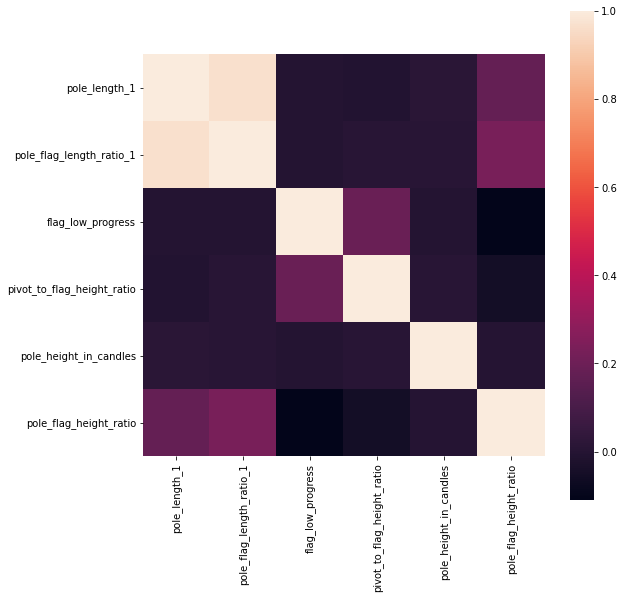

In [24]:
#correlation matrix
corrmat = features_only.corr()
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(corrmat, square=True);

Looking at this correlation map, we can see that pole_flag_length_ratio_1 and pole_length_1 have a very strong correlation. Otherwise, all other features are decoupled. The least correlation is between the progress at which a flag makes its lowest low and the pole height to flag height ratio.

## Data clean up

Let us check how much missing data we have in this dataset.

In [25]:
#missing data
total = features_label_df.isnull().sum().sort_values(ascending=False)
percent = (features_label_df.isnull().sum()/features_label_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
label_class_2_num_of_lows_2_profit_r,2399,0.006169
pivot_to_flag_height_ratio,1202,0.003091
pole_flag_length_ratio_1,212,0.000545
pole_length_1,212,0.000545
flag_low_progress,122,0.000314
pole_flag_height_ratio,75,0.000193
pole_height_in_candles,2,0.000005


Hmm, I expected these to be non-existent, but I am glad that we checked:) Over all, even 'label_class_2_num_of_lows_2_profit_r', the highest with missing data, is less than 0.01% of our data.

To deal with this data, we are just going to delete the entries with missing values.


In [26]:
features_label_df = features_label_df.dropna()
features_label_df.shape

(384895, 7)

Let's verify that there are no more null values in the dataset

In [27]:
features_label_df.isnull().sum().max() #

0

Now, let's see if there are any infinity values in the dataset

In [28]:
features_label_df.describe()

,pole_length_1,pole_flag_length_ratio_1,flag_low_progress,pivot_to_flag_height_ratio,pole_height_in_candles,pole_flag_height_ratio
count,384895.000000,384895.000000,384895.000000,384895.000000,3.848950e+05,384895.000000
mean,13.290609,1.091648,0.605796,0.591151,inf,1.749871
std,8.333873,0.962350,0.230863,0.478634,NaN,2.459774
min,2.000000,0.046512,0.022727,0.000036,7.521393e-04,0.003546
25%,7.000000,0.428571,0.444444,0.381157,4.211045e+00,0.904444
50%,11.000000,0.800000,0.636364,0.603261,5.915215e+00,1.351464
75%,17.000000,1.444444,0.791667,0.790463,8.590208e+00,2.039076
max,76.000000,11.833333,1.000000,34.000000,inf,227.400000


There are some weird values in "pole_height_in_candles". Let's remove them.

In [29]:
features_label_df.replace([np.inf, -np.inf], np.nan, inplace=True)
features_label_df = features_label_df.dropna()

In [30]:
features_label_df.shape

(384890, 7)

In [31]:
features_label_df.describe()

,pole_length_1,pole_flag_length_ratio_1,flag_low_progress,pivot_to_flag_height_ratio,pole_height_in_candles,pole_flag_height_ratio
count,384890.000000,384890.000000,384890.000000,384890.000000,384890.000000,384890.000000
mean,13.290665,1.091652,0.605803,0.590847,25.273414,1.749595
std,8.333913,0.962355,0.230857,0.471142,1696.566691,2.458597
min,2.000000,0.046512,0.022727,0.000036,0.000752,0.003546
25%,7.000000,0.428571,0.444444,0.381148,4.211045,0.904396
50%,11.000000,0.800000,0.636364,0.603261,5.915093,1.351417
75%,17.000000,1.444444,0.791667,0.790456,8.590208,2.039076
max,76.000000,11.833333,1.000000,34.000000,264116.139600,227.400000


In [32]:
features_label_df.head()

,pole_length_1,pole_flag_length_ratio_1,flag_low_progress,pivot_to_flag_height_ratio,pole_height_in_candles,pole_flag_height_ratio,label_class_2_num_of_lows_2_profit_r
0,21.0,1.909091,0.333333,0.849126,6.528945,1.067483,True
1,21.0,1.400000,0.250000,0.765210,6.528945,1.067483,False
2,21.0,1.400000,0.250000,0.793182,6.528945,1.067483,False
3,21.0,3.500000,0.571429,0.947028,6.528945,1.067483,False
4,21.0,2.333333,0.400000,0.891084,6.528945,1.067483,False


Another thing I would like to address is large decimal places. They are not necessary in such excessive amounts, and they are going to slow down the training without giving much value to the model.

We are going to round all features to 3 decimal places.

In [33]:
features_label_df = features_label_df.round(3)

features_label_df.head()

,pole_length_1,pole_flag_length_ratio_1,flag_low_progress,pivot_to_flag_height_ratio,pole_height_in_candles,pole_flag_height_ratio,label_class_2_num_of_lows_2_profit_r
0,21.0,1.909,0.333,0.849,6.529,1.067,True
1,21.0,1.400,0.250,0.765,6.529,1.067,False
2,21.0,1.400,0.250,0.793,6.529,1.067,False
3,21.0,3.500,0.571,0.947,6.529,1.067,False
4,21.0,2.333,0.400,0.891,6.529,1.067,False


Now, let's split the data into x and y, and preprocess the X values by scaling them

In [34]:
y_df = features_label_df["label_class_2_num_of_lows_2_profit_r"]
x_df = features_label_df.drop("label_class_2_num_of_lows_2_profit_r", axis=1)
x_df = x_df.astype(float)

In [35]:
x = x_df.values
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
x_df = pd.DataFrame(x_scaled, columns=x_df.columns)
x_df.tail()

,pole_length_1,pole_flag_length_ratio_1,flag_low_progress,pivot_to_flag_height_ratio,pole_height_in_candles,pole_flag_height_ratio
384885,0.685073,-0.428791,0.512045,0.598871,-0.010116,-0.267061
384886,0.685073,1.059224,-1.324658,0.390865,-0.010116,-0.238996
384887,0.685073,-0.428791,0.512045,0.543686,-0.010116,-0.267061
384888,0.685073,1.059224,-1.324658,0.524583,-0.010116,-0.238996
384889,0.685073,1.059224,-1.324658,0.371763,-0.010116,-0.238996


Lastly for this section, let's split up between training and testing data

In [36]:
all_y_df = y_df.reset_index(drop=True)
everything = x_df.reset_index(drop=True)
everything["label"] = all_y_df

In [37]:
# leaving out only 10% of the dataset because it's pretty big, and I don't need so much of it to be tested
all_train, all_test = train_test_split(everything, test_size=0.1, random_state=42, shuffle=True)

print("Sanity check before training check")
print(all_train.shape)
print(all_test.shape)
print(all_train.sample(10))

Sanity check before training check
(346401, 7)
(38489, 7)
        pole_length_1  pole_flag_length_ratio_1  ...  pole_flag_height_ratio  label
66971       -0.754828                 -0.225124  ...               -0.387862  False
347816      -0.994812                 -0.701039  ...               -0.386235   True
190700      -0.034877                  0.216500  ...               -0.587163   True
39244        0.685073                  1.333550  ...                0.880750  False
181373      -1.354787                 -0.788325  ...                0.195398   True
310942      -0.754828                 -0.473473  ...               -0.313429   True
287267      -0.154869                 -0.400735  ...               -0.010410   True
313571      -1.114804                 -0.814303  ...               -0.250385   True
134936      -0.394853                  0.597856  ...                0.096968  False
174087      -1.114804                 -0.926527  ...               -0.239810   True

[10 rows x 7 colu

# Training classifiers

I will be training on 3 classifiers: decision tree, random forest, support vector machine.

In [38]:
# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [39]:
'''
params:
  classifier -> sklearn classifier object
  x_array -> training data as numpy 2d array 
  y_array -> training data as labeling
purpose:
  trains the classifier and returns it
'''
def train_classifier(classifier, x_array, y_array):
  return classifier.fit(x_array, y_array)

In [40]:
'''
params:
  y_pred -> predictions calculated by the classifier 
  y_test -> actual labels
purpose:
  displays the confusion matrix
'''
def show_confusion_matrix(y_pred, y_test):
  cm = confusion_matrix(y_pred, y_test)

  labels = ["Fakeout", "Breakout"]

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

In [41]:
'''
params:
  y_pred -> predictions calculated by the classifier 
  y_test -> actual labels
purpose:
  displays the accuracy
'''
def show_accuracy(y_pred, y_test):
  print("Accuracy:", accuracy_score(y_test, y_pred))

In [45]:
X_train = all_train.drop("label", axis=1)
y_train = all_train["label"]

X_test = all_test.drop("label", axis=1)
y_test = all_test["label"]

## Training Decision Tree classifier

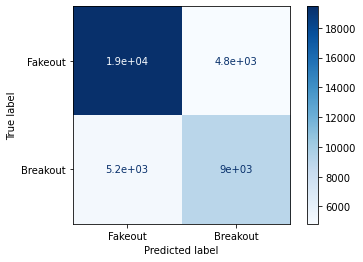

Accuracy: 0.7400296188521396


In [46]:
# creating, training, predicting using forest
tree_clf = DecisionTreeClassifier()
tree_clf = train_classifier(tree_clf, X_train.values, y_train.values)
tree_y_pred = tree_clf.predict(X_test.values)

# showing metrics
show_confusion_matrix(tree_y_pred,  y_test.values)
show_accuracy(tree_y_pred, y_test.values)


## Training Random Forest classifier

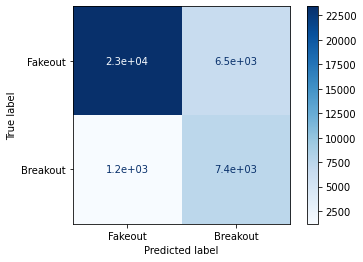

Accuracy: 0.8006443399412819


In [47]:
# creating, training, predicting using forest
forest_clf = RandomForestClassifier()
forest_clf = train_classifier(forest_clf, X_train.values, y_train.values)
forest_y_pred = forest_clf.predict(X_test.values)

# show metrics
show_confusion_matrix(forest_y_pred,  y_test.values)
show_accuracy(forest_y_pred, y_test)

## Training Support Vector Machine

In [ ]:
# creating, training, predicting using SVM
svc_clf = SVC()
svc_clf = train_classifier(svc_clf, X_train.values, y_train.values)
svc_y_pred = svc_clf.predict(X_test.values)

# show metrics

show_confusion_matrix(svc_y_pred,  y_test.values)
show_accuracy(svc_y_pred, y_test)

## Models' performance evaluation

SVM and Random Forest have equally high predictions. However, if I look exclusively at who predicts a breakout more times successfully, then it is a decision tree. Its accuracy is worse, but if I relied on this model exclusively making breakout calls, I would have been profitable. Out of the times it called out a successful breakout, it was correct 65% (9.1 / 13.9) of the time. We essentially flipped our expected value from the start of the notebook.


In [1]:
print("Expected value of decision tree classifier")
p_right = 0.65
r_right = 2

p_wrong = 0.35
r_wrong = 1

round(p_right * r_right - p_wrong * r_wrong, 2)

Expected value of decision tree classifier


0.95

## Conclusion

I am excited, to be honest. I probably should double check everything, but this has exceeded my expectations by a big margin (expecially after a fail during neural network training, which as you see I excluded).

Having only baseline models perform this way is promising! With certain hyperparameter tuning, I am sure it's possible to bump up the accuracy by a few percent. Also I ahve not yet properly trained on a neural network, which has quite high variance and could be even better for a training set of this size than other classifiers tested.

Also, considering that I only have 6 features being used in a set of about 400k entries, there's lots of potential here if I add just a couple/few more features that I did not have time to implement. At this point right now, each stock trendline is isolated by itself. I believe there will be another improvement in the model if I add some kind of perfomance relationship with a benchmark index like SPY (ex. how well did the stock perform during the pole formation or flag formation relative to how SPY performed?). Perhaps, I can also (or instead of SPY) add a sector index relationship to the stock's performance. Maybe it's also possible to deduce the stock's index performance relative to other indices.

After bumping up the model number a bit more and fully inspecting the code/math a couple of times, the next part of this ongoing project would be bring this model into live trading environment. Perhaps, it could start as a live scan at first and gradually be translated into a live trading bot.